# Diagnostic du cancer du sein à partir de données d’expression de gènes
***

Cet article utilise les données réelles d’expression de gènes dans le cancer du sein. Il s’agit des données de séquençage du génome (RNA-seq) issues de la base de données publique TCGA (programme Atlas de génome de cancer) du portail public [UCSC Xena](http://xena.ucsc.edu/public). Ces données sont deja pré-traitées : alignées, normalisées selon une transformation log2(x+1). Elles sont prêtes pour l’analyse.

Nous allons extraire les données par programmation à partir de [l'API Python de l'UCSC Xena](https://ucsc-xena.gitbook.io/project/overview-of-features/accessing-data-through-python). Ensuite à partir des frameworks Hadoop et Spark, nous allons pré-traiter et charger les données dans un Data Lake HDFS avant de les analyser.

In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pandas as pd
import xenaPython as xena

In [3]:
ss = SparkSession.builder.config(conf=SparkConf()).getOrCreate()

## 1. Extraction des données
***

In [4]:
hub = "https://tcga.xenahubs.net"
phenotype_dataset = "TCGA.BRCA.sampleMap/BRCA_clinicalMatrix"
gene_dataset = "TCGA.BRCA.sampleMap/HiSeqV2_PANCAN"

In [5]:
def get_codes(host, dataset, fields, data):
    codes = xena.field_codes(host, dataset, fields)
    codes_idx = dict([(x['name'], x['code'].split('\t')) for x in codes if x['code'] is not None])
    for i in range(len(fields)):
        if fields[i] in codes_idx:
            data[i] = [None if v == 'NaN' else codes_idx[fields[i]][int(v)] for v in data[i]]
    return data


def get_fields(host, dataset, samples, fields):
    data = xena.dataset_fetch(host, dataset, samples, fields)
    return data


def get_fields_and_codes(host, dataset, samples, fields):
    return get_codes(host, dataset, fields, get_fields(host, dataset, samples, fields))

In [6]:
GENES = ['UBE2T', 'BIRC5', 'NUF2', 'CDC6', 'CCNB1', 'TYMS', 'MYBL2',
         'CEP55', 'MELK', 'NDC80', 'RRM2', 'UBE2C', 'CENPF', 'PTTG1',
         'EXO1', 'ORC6L', 'ANLN', 'CCNE1', 'CDC20', 'MKI67', 'KIF2C',
         'ACTR3B', 'MYC', 'EGFR', 'KRT5', 'PHGDH', 'CDH3', 'MIA', 'KRT17',
         'FOXC1', 'SFRP1', 'KRT14', 'ESR1', 'SLC39A6', 'BAG1', 'MAPT', 'PGR',
         'CXXC5', 'MLPH', 'BCL2', 'MDM2', 'NAT1', 'FOXA1', 'BLVRA', 'MMP11',
         'GPR160', 'FGFR4', 'GRB7', 'TMEM45B', 'ERBB2']
fields = ["sampleID", "sample_type", "PAM50Call_RNAseq"]

In [7]:
dataset_samples = xena.dataset_samples(hub, phenotype_dataset, None)
values = get_fields_and_codes(hub, phenotype_dataset, dataset_samples, fields)
expression = get_fields(hub, gene_dataset, dataset_samples, GENES)

In [8]:
phenotypes = dict(zip(fields, values))
expression_by_gene = dict(zip(GENES, expression))
data = dict(phenotypes, **expression_by_gene)

## 2. Prétraitement et chargement des données sur HDFS
***

In [9]:
df = pd.DataFrame.from_dict(data)
df = df.set_index('sampleID')
df.shape


(1247, 52)

In [10]:
df = df[df.sample_type == "Primary Tumor"]
df = df.drop(['sample_type'], axis=1)
df = df.dropna()
num_columns = [col for col in df.columns if col != 'PAM50Call_RNAseq']
columns = num_columns + ['PAM50Call_RNAseq']
df = df[columns]
df[num_columns] = df[num_columns].apply(pd.to_numeric)
df = df.astype({'PAM50Call_RNAseq': 'string'})
df.shape

(844, 51)

Les données extraites correspondent aux niveaux d’expression de 50 gènes (UBE2T, BIRC5, NUF2, etc.) dans différents échantillons (821 au total). La dernière colonne nommée PAM50Call_RNAseq contient le sous-type moléculaire du cancer du sein PAM50, mesuré pour chaque échantillon. Cinq sous-types moléculaires sont disponibles : Luminal-A, Luminal-B, HER2, Basal et Normal. Le cancer du sein de type Luminal-A a généralement un bon pronostic pour les patients. En revanche, le cancer du sein de type Basal a souvent un pronostic sombre.

In [11]:
df.head()

,UBE2T,BIRC5,NUF2,CDC6,CCNB1,TYMS,MYBL2,CEP55,MELK,NDC80,...,NAT1,FOXA1,BLVRA,MMP11,GPR160,FGFR4,GRB7,TMEM45B,ERBB2,PAM50Call_RNAseq
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SB-01,-1.05000,-0.5723,-0.91170,-0.06508,-0.5442,0.01196,-0.1140,-0.5534,-0.2772,-0.7020,...,-0.7535,2.504,-0.560000,-1.193,-1.379,-1.9090,1.223,-1.7280,1.150,Normal
TCGA-A1-A0SD-01,-0.69440,-0.2286,-0.09701,-0.63190,0.0273,-1.50700,-0.0924,0.3095,0.2002,-0.8004,...,4.2010,6.424,0.555800,3.670,2.148,2.5770,2.018,1.1450,2.103,LumA
TCGA-A1-A0SE-01,1.16800,0.4836,0.75460,0.41780,0.8455,-0.47570,0.6677,0.8303,0.7009,0.5369,...,5.3330,6.364,1.313000,3.505,1.980,-0.6855,1.407,-0.7139,1.623,LumA
TCGA-A1-A0SF-01,-0.09457,-0.7442,0.12760,0.13790,0.2594,-0.50990,0.8460,0.1982,0.3672,0.1041,...,6.3440,6.133,1.346000,1.620,2.691,1.3730,1.465,-0.6391,1.400,LumA
TCGA-A1-A0SG-01,-0.66240,-0.4675,-0.81910,-0.43190,-0.1620,-0.56110,-0.5934,-0.1494,-0.3621,-0.5939,...,0.5624,5.967,-0.003845,4.864,1.451,2.7300,1.045,1.8710,1.818,LumA


In [12]:
input_sparkDF=ss.createDataFrame(df)

C:\Users\a840702\Miniconda3\envs\pyspark_env\lib\site-packages\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\a840702\Miniconda3\envs\pyspark_env\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [13]:
input_sparkDF.write.save('/data/brca/', format='parquet', mode='append')

## 3. Visualisation de données multidimensionnelles et réduction de variables
***
 Affichons le nombre d'échantillons dans chaque sous-type moléculaire.

In [14]:
sparkDF = ss.read.format('parquet').load('/data/brca/')
df = sparkDF.toPandas()

In [15]:
df.groupby(['PAM50Call_RNAseq']).size()

PAM50Call_RNAseq
Basal      423
Her2       201
LumA      1263
LumB       576
Normal      46
dtype: int64

<AxesSubplot: xlabel='PAM50Call_RNAseq'>

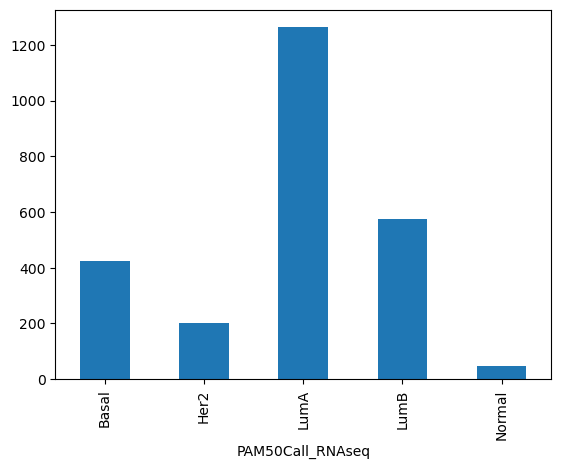

In [16]:
df.groupby(['PAM50Call_RNAseq']).size().plot(kind="bar")

On peut remarquer que les données ne sont pas distribuées de façon homogène selon le type de cancer. En effet, le cancer du sein de type Luminal-A survient plus fréquemment dans la population générale par rapport aux autres sous-types moléculaires de ce cancer.

### 3.1. Séparation des données d’expression et des étiquettes
***

Pour réaliser le calcul sur les données d’expression, il nous sera plus pratique de séparer les valeurs numériques des expressions de gènes et les étiquettes des sous-types moléculaires pam50 dans deux objets différents.

En suivant la nomenclature standard acceptée dans `scikit-learn`, on nommera **X** la matrice de données d’expression et **y** les étiquettes correspondantes.

In [17]:
# Données d'expression de 50 gènes
X = df.select_dtypes('number')
print('X', X.shape)

X (2509, 50)


In [18]:
# étiquettes correspondantes (sous-types moléculaires)
y = df['PAM50Call_RNAseq']
print('y', y.shape)

y (2509,)


### 3.2. Valeurs d'expression
***

Affichons les valeurs d'expression pour chaque gène, rangées par leurs moyennes.

<AxesSubplot: ylabel='Expression'>

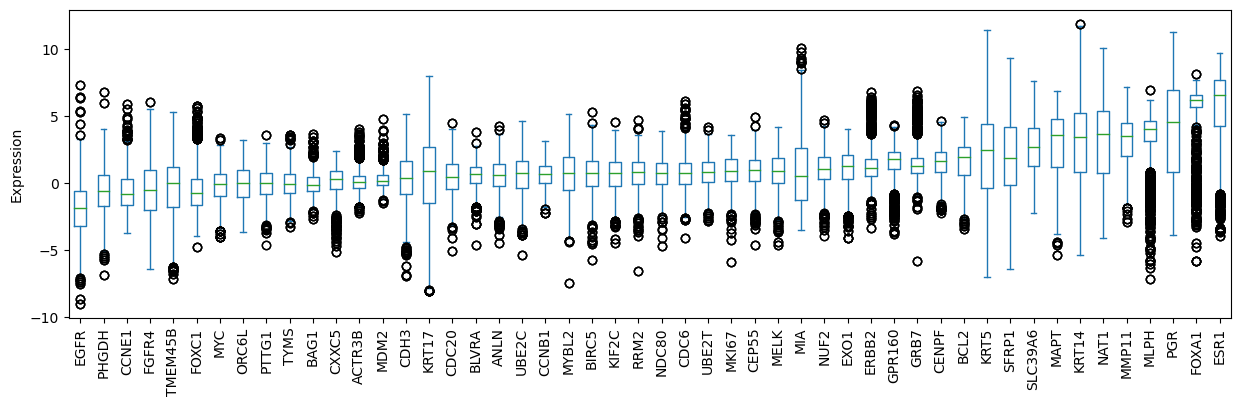

In [19]:
sort_by_mean = X.mean().sort_values(ascending=True)
X[sort_by_mean.index].plot(kind='box', figsize=(15, 4), rot=90, ylabel='Expression')

Pour certains gènes les niveaux d’expression varient beaucoup, pour d’autres non. Les plages de valeurs sont différentes d’un gène à l’autre. Cette situation peut impacter fortement une analyse en composantes principales (ACP) qui est principalement basée sur la variance. Les gènes avec une forte variance absolue auront plus de poids dans l’analyse que ceux avec une faible variance. Pour cette raison, les données doivent être obligatoirement normalisées (standardisées) avant l’analyse.

### 3.3. Normalisation centrée-réduite des données
***

La normalisation (standardisation) centrée-réduite consiste à soustraire la moyenne et à diviser par l'écart-type les valeurs d'expression.

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # instanciation de l'objet scaler
X_scaled = scaler.fit_transform(X)  # normalisation centrée-réduite
X_scaled = pd.DataFrame(X_scaled, index=X.index,
                        columns=X.columns)  # conversion du résultat en objet dataframe de pandas

Les valeurs d'expression sont ramenées à la même échelle après une normalisation centrée-réduite. La moyenne d’expression de chaque gène est égale à 0 et l'écart type est égal à 1.

<AxesSubplot: ylabel='Expression'>

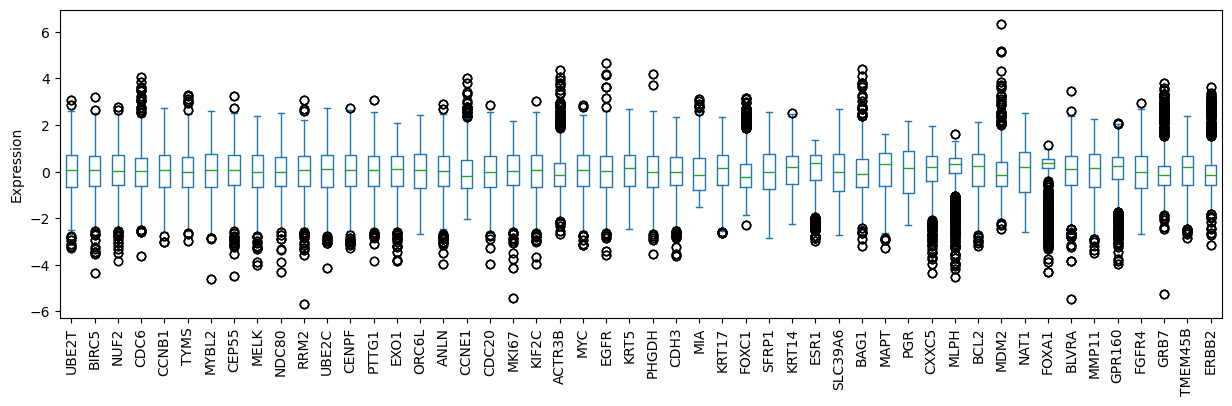

In [21]:
X_scaled.plot(kind='box', figsize=(15, 4), rot=90, ylabel='Expression')

### 3.4. Analyse en composantes principales (ACP)
***

In [22]:
from sklearn.decomposition import PCA

#### 3.4.1. Calcul de l'ACP
***

Pour calculer une ACP, on utilise les données standardisées **X_scaled**.

In [23]:
pca = PCA()  # instanciation de l'objet pca
X_pca = pca.fit_transform(X_scaled)  # réalisation de l'ACP sur les données X_scaled

Il est plus pratique de convertir le résultat de l'ACP **X_pca** en dataframe pandas, en précisant les noms de colonnes : de *PC1* à *PC50*. 

In [24]:
# Conversion en dataframe pandas
pca_columns = ['PC' + str(c) for c in
               range(1, X_pca.shape[1] + 1, 1)]  # création d'une liste avec les noms de colonnes de PC1 à PC50
X_pca = pd.DataFrame(X_pca, index=X.index, columns=pca_columns)  # création du dataframe
X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,3.814079,1.843486,-0.058451,1.069570,0.989343,0.940787,1.888662,0.198003,1.522452,-0.138454,...,0.088394,0.232925,-0.175817,0.023601,-0.127763,0.025089,0.007396,-0.377167,-0.168324,-0.089846
1,0.929302,-0.537552,-1.384739,-2.417305,0.599240,0.938677,-1.353989,1.345455,-1.154055,0.369151,...,0.691327,0.499653,0.223050,0.042526,0.146541,-0.141994,-0.115876,0.043234,-0.117513,0.333765
2,3.680124,2.693146,0.016208,0.078265,-0.304874,-0.849238,-0.304385,-0.489324,-0.586466,-0.324156,...,0.351482,0.215855,-0.389381,0.268327,-0.079635,-0.287968,0.215311,-0.229071,0.043174,0.167033
3,-8.744451,2.698509,0.392283,-2.141396,1.892824,-0.689205,0.084020,-0.201405,0.099060,0.929380,...,-0.372698,-0.273483,-0.017494,-0.062332,0.268400,0.064543,-0.032884,-0.055719,0.010921,-0.200206
4,0.486317,-0.849387,0.573815,-2.116671,-0.192280,-0.343926,0.742175,-0.211640,0.253016,0.944544,...,-0.051639,-0.262310,0.039222,0.043686,0.187871,-0.569148,-0.444176,-0.040368,0.418996,0.010462


#### 3.4.2. Calcul de la variance expliquée
***

Les valeurs de la variance expliquée par composante sont disponibles dans l’attribut `pca.explained_variance_ratio_` après le calcul de l'ACP.

In [25]:
pca.explained_variance_ratio_

array([0.41943514, 0.15346231, 0.05919598, 0.05050353, 0.02872744,
       0.0221299 , 0.02095083, 0.01908917, 0.01743119, 0.01700727,
       0.01357013, 0.01197019, 0.01164491, 0.01064912, 0.00947497,
       0.00934593, 0.00840761, 0.00777433, 0.00759623, 0.00705205,
       0.00657588, 0.00616141, 0.00610191, 0.00573423, 0.00531631,
       0.00480053, 0.00452488, 0.00436215, 0.00382482, 0.00370016,
       0.00354586, 0.00332845, 0.00318113, 0.00301297, 0.00290394,
       0.00277775, 0.0026706 , 0.00250737, 0.00239106, 0.00223526,
       0.00191229, 0.00180989, 0.00175489, 0.0017036 , 0.00162536,
       0.00149949, 0.00143877, 0.00125782, 0.00101568, 0.00090729])

On peut les convertir en objet `Series` de pandas et présenter les valeurs en pourcentage.

In [26]:
explained_variance = pd.Series(dict(zip(X_pca.columns, 100.0 * pca.explained_variance_ratio_)))
print(explained_variance.head())

PC1    41.943514
PC2    15.346231
PC3     5.919598
PC4     5.050353
PC5     2.872744
dtype: float64


<AxesSubplot: ylabel='Explained variance'>

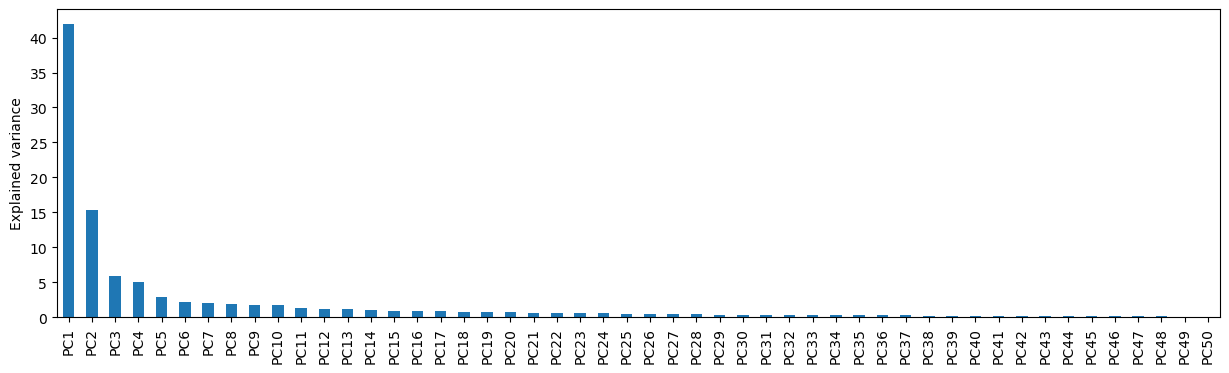

In [27]:
explained_variance.plot(kind='bar', figsize=(15, 4), rot=90, ylabel='Explained variance')

In [28]:
explained_variance['PC1'] + explained_variance['PC2']

57.28974561666196

Les deux premières composantes de l'ACP expliquent **57.04%** de la variance.

In [29]:
explained_variance['PC1'] + explained_variance['PC2'] + explained_variance['PC3']

63.20934385641008

Les trois premières composantes de l'ACP expliquent **62.9%** de la variance.

#### 3.4.3. Visualisation des deux premières composantes principales de l’ACP
***

<AxesSubplot: xlabel='PC1', ylabel='PC2'>

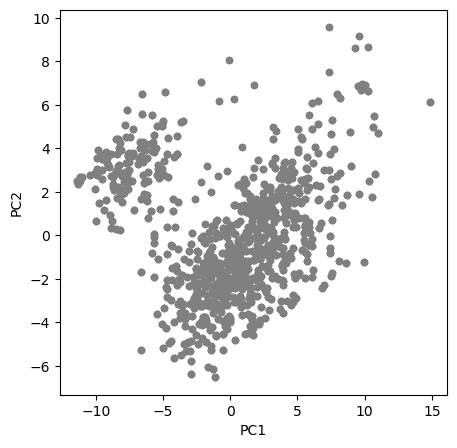

In [30]:
X_pca.plot(x='PC1', y='PC2', kind='scatter', figsize=(5, 5), color='gray')

Les points se rassemblent naturellement en clusters, notamment deux clusters sont nettement visibles. Présentons chaque sous-type moléculaire en différente couleur pour comprendre à quoi correspondent ces clusters.

In [31]:
import matplotlib.pyplot as plt

In [ ]:
dict_colors = {'LumA': 'forestgreen', 'LumB': 'royalblue', 'Her2': 'orange', 'Basal': 'crimson', 'Normal':'purple'}
y_colors = [dict_colors[yi] for yi in y]

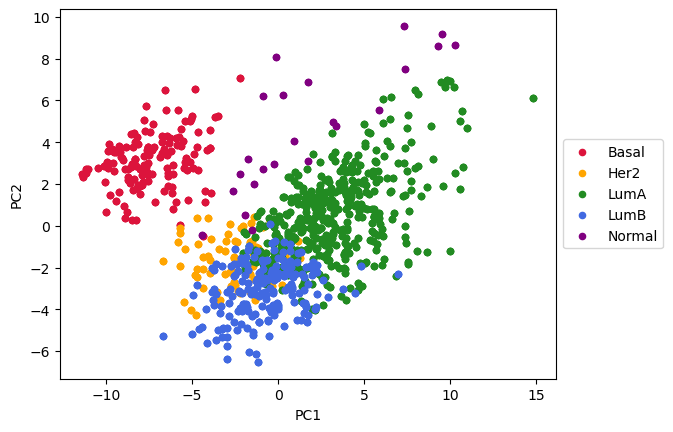

In [32]:
X_pca['PAM50Call_RNAseq'] = y
fig, ax = plt.subplots()
grouped = X_pca.groupby('PAM50Call_RNAseq')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='PC1', y='PC2', label=key, color=dict_colors[key])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

#### 3.4.4. Visualisation des trois premières composantes principales de l’ACP
***

Pour créer une image en 3D, on utilisera la librairie standard `matplotlib` de Python.

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

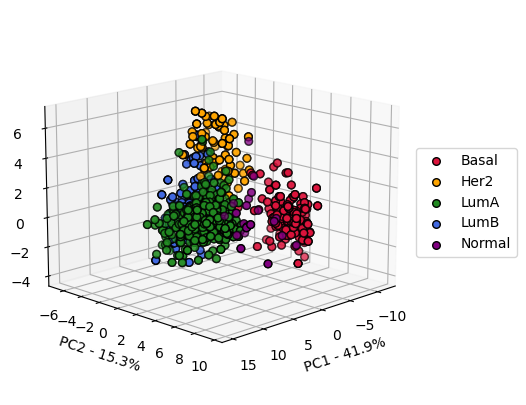

In [34]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
for key, group in grouped:
    ax.scatter(group['PC1'], group['PC2'], group['PC3'], marker='o', s=30, edgecolor='k', label=key, color=dict_colors[key])
ax.set_xlabel('PC1 - ' + '{:.1f}%'.format(explained_variance['PC1']))
ax.set_ylabel('PC2 - ' + '{:.1f}%'.format(explained_variance['PC2']))
ax.set_zlabel('PC3 - ' + '{:.1f}%'.format(explained_variance['PC3']))
ax.view_init(elev=15, azim=45)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### 3.5. T-SNE
***

In [35]:
from sklearn.manifold import TSNE

#### 3.5.1. Projection 2D
***

In [36]:
tsne = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1)
X_tsne = tsne.fit_transform(X_scaled)

In [37]:
columns = ['DIM' + str(c) for c in range(1, X_tsne.shape[1] + 1, 1)]
X_tsne = pd.DataFrame(X_tsne, index=X.index, columns=columns)
X_tsne.head()

,DIM1,DIM2
0,66.853691,2.827511
1,2.586437,-19.407452
2,72.740547,54.040649
3,-59.868412,65.664040
4,-1.153517,5.759010


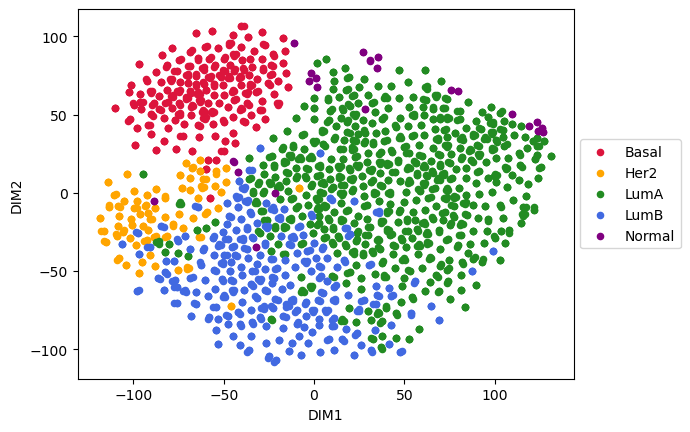

In [38]:
X_tsne['PAM50Call_RNAseq'] = y
fig, ax = plt.subplots()

grouped = X_tsne.groupby('PAM50Call_RNAseq')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='DIM1', y='DIM2', label=key, color=dict_colors[key])

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [39]:
# La divergence de Kullback-Leibler après optimisation
tsne.kl_divergence_

0.27850791811943054

#### 3.5.2. Projection 3D
***

In [40]:
tsne = TSNE(n_components=3, init='pca', perplexity=45, random_state=0, n_jobs=-1)
X_tsne = tsne.fit_transform(X_scaled)

In [41]:
columns = ['DIM' + str(c) for c in range(1, X_tsne.shape[1] + 1, 1)]
X_tsne = pd.DataFrame(X_tsne, index=X.index, columns=columns)
X_tsne.head()

,DIM1,DIM2,DIM3
0,26.285061,6.813632,28.341663
1,0.985476,-4.137661,-25.626959
2,33.081066,20.029961,2.030272
3,-22.605268,27.308077,-17.187069
4,-0.520667,9.091275,-8.869629


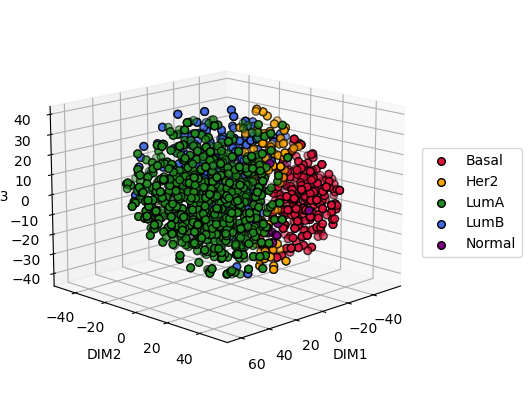

In [42]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
X_tsne['PAM50Call_RNAseq'] = y
grouped = X_tsne.groupby('PAM50Call_RNAseq')
for key, group in grouped:
    ax.scatter(group['DIM1'], group['DIM2'], group['DIM3'], marker='o', s=30, edgecolor='k', label=key, color=dict_colors[key])
ax.set_xlabel('DIM1')
ax.set_ylabel('DIM2')
ax.set_zlabel('DIM3')
ax.view_init(elev=15, azim=45)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [43]:
tsne.kl_divergence_

0.02553291991353035

### 3.6. UMAP
***

In [44]:
import umap

#### 3.6.1. Projection 2D
***

In [45]:
embedding = umap.UMAP(n_components=2, random_state=0, n_jobs=-1)
X_umap = embedding.fit_transform(X_scaled)
columns = ['DIM' + str(c) for c in range(1, X_umap.shape[1] + 1, 1)]
X_umap = pd.DataFrame(X_umap, index=X.index, columns=columns)

C:\Users\a840702\Miniconda3\envs\pyspark_env\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


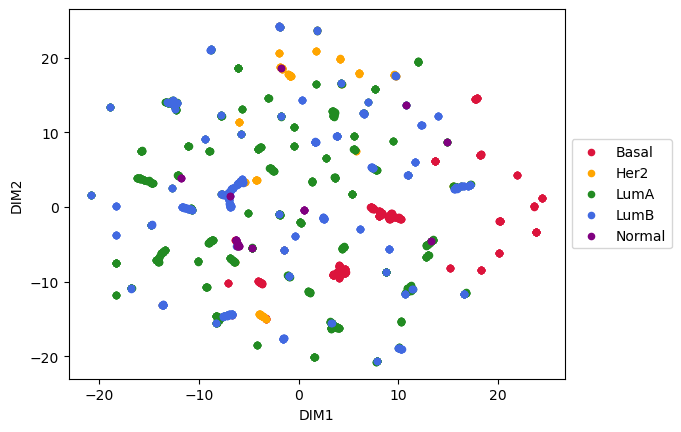

In [46]:
X_umap['PAM50Call_RNAseq'] = y
fig, ax = plt.subplots()
grouped = X_umap.groupby('PAM50Call_RNAseq')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='DIM1', y='DIM2', label=key, color=dict_colors[key])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

#### 3.6.2. Projection 3D
***

In [47]:
embedding = umap.UMAP(n_components=3, random_state=0, n_jobs=-1)
X_umap = embedding.fit_transform(X_scaled)
columns = ['DIM' + str(c) for c in range(1, X_umap.shape[1] + 1, 1)]
X_umap = pd.DataFrame(X_umap, index=X.index, columns=columns)

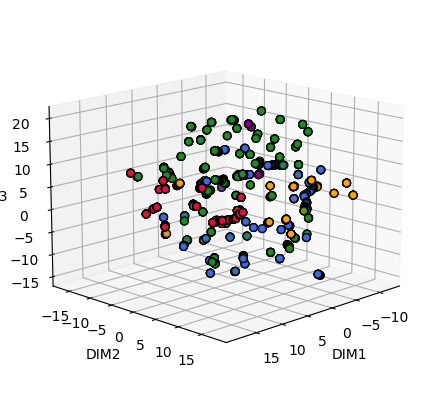

In [48]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_umap['DIM1'], X_umap['DIM2'], X_umap['DIM3'], marker='o', s=30, edgecolor='k', facecolor=y_colors)
ax.set_xlabel('DIM1')
ax.set_ylabel('DIM2')
ax.set_zlabel('DIM3')
ax.view_init(elev=15, azim=45)